In [1]:
import pandas as pd
import requests as rq
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing, model_selection
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from google.colab import drive
#import sweetviz as sw
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, r2_score

import itertools
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler

In [2]:
def plot_confusion_matrix(cm, classes,normalize=False,title=None,cmap=plt.cm.Greens):
  plt.imshow(cm, interpolation = 'nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation = 45)
  plt.yticks(tick_marks, classes)
  
  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion matrix, without normalization")
  
  print(cm)
  
  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j, i, cm[i,j], horizontalalignment="center", color="white" if cm[i,j]>thresh else "black")
   
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
simplefilter(action='ignore', category=FutureWarning)

In [5]:
df = pd.read_csv('drive/MyDrive/Projeto TCC Pós Graduação/nfl-big-data-bowl-2020/train.csv', low_memory=False)

In [6]:
#Adicao de coluna mostrando o resultado de cada jogada (Ganho de Jardas, First Down, Turn Over...)
df['ResultAfterMove'] = np.where(df['Yards']<0,'Perda de jardas',np.where(df['Yards']>=df['Distance'],'FirstDown',np.where(df['Down']==4,'Turn Over on Downs',np.where(['Yards']==0,'Sem avanço','Avanco sem First Down'))))

In [7]:
#Criação de Key com GameID e PlayId
#Criação de coluna IsHomeTeam, exibindo true para times que estão jogando em casa e 0 para times visitantes.
df['key'] = df['GameId'].map(str)+'-'+df['PlayId'].map(str)
df['IsHomeTeam'] = df['Team'].map({'away': 0, 'home': 1})
df = df.drop(df[['GameId','PlayId','Team']],axis=1)
df = df.set_index('key')

X,y = df.drop('Yards',axis=1), df['Yards']


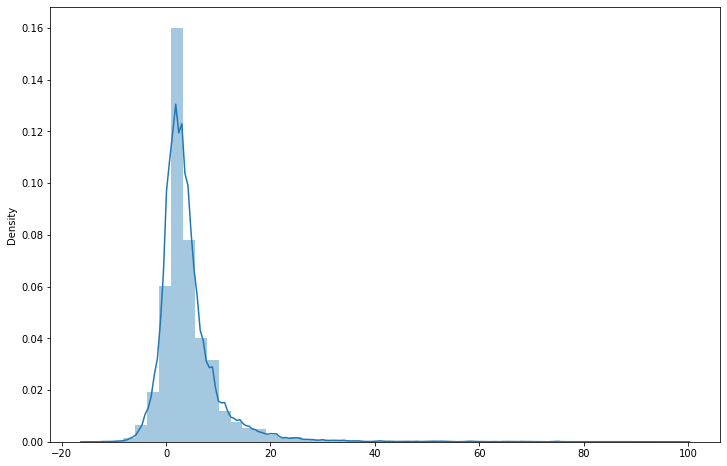

In [8]:
#Distribuição de jardas
ax = sns.distplot(y.values)
ax.figure.set_size_inches(12,8)

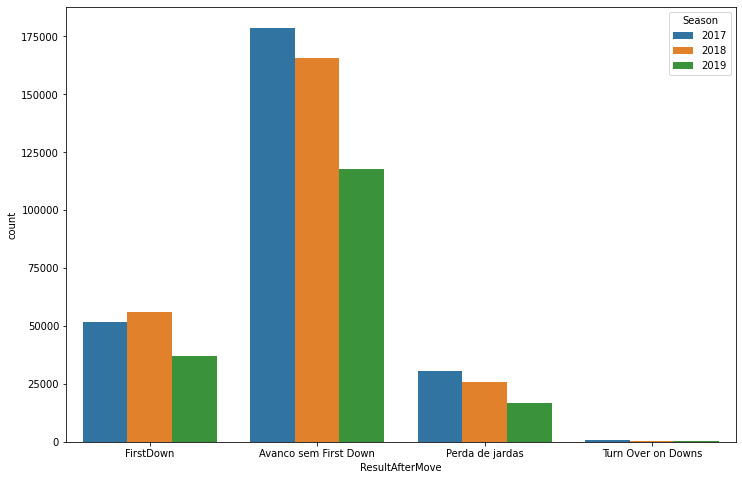

In [9]:
ax = sns.countplot(df['ResultAfterMove'],hue=df['Season'])
ax.figure.set_size_inches(12, 8)

In [10]:
#Separação de dataset entre treino e teste, usando Y para estratificação.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3, stratify=y)

In [11]:
#Validação da quantidade de valores nulos em cada coluna
X_train.isna().sum().sort_values(ascending=False)

WindDirection             73113
WindSpeed                 64199
Temperature               44501
GameWeather               42063
StadiumType               29213
FieldPosition              6055
Humidity                   4340
OffenseFormation             65
Orientation                  18
Dir                          18
DefendersInTheBox            17
PlayerHeight                  0
PlayerWeight                  0
PlayerBirthDate               0
PlayerCollegeName             0
Position                      0
Location                      0
HomeTeamAbbr                  0
VisitorTeamAbbr               0
Week                          0
Stadium                       0
TimeHandoff                   0
Turf                          0
ResultAfterMove               0
TimeSnap                      0
X                             0
PlayDirection                 0
Quarter                       0
S                             0
A                             0
Dis                           0
NflId   

In [12]:
#Função para processamento da coluna WindSpeed
#Caso o valor seja numérico, retonará o valor, em casos que contem texto junto ao numero, ex: mph, retornará apenas o valor numerico.
#Em casos que existem ranges de velocidade, ex: '11 - 20', retornará a média entre os dois valores. 
def windspeed(x):
    x=str(x)
    if x.isdigit():
        return int(x)
    elif (x.isalpha()):
        return 0
    elif (x.isalnum()):
        return int(x.upper().split('M')[0])
    elif '-' in x:
        return int((int(x.split('-')[0])+int(x.split('-')[1]))/2)
    else:
        return 0

In [13]:
# Aplicação de função para processamento da coluna WindSpeed no dataset de treino
X_train['WindSpeed']=X_train['WindSpeed'].apply(windspeed)
# Preenchimento dos valores nulos com a média da coluna
X_train['WindSpeed'].fillna(X_train['WindSpeed'].mean(),inplace=True)

In [14]:
# Aplicação de função para processamento da coluna WindSpeed no dataset de teste
X_test['WindSpeed']=X_test['WindSpeed'].apply(windspeed)
# Preenchimento dos valores nulos com a média da coluna
X_test['WindSpeed'].fillna(X_test['WindSpeed'].mean(),inplace=True)

In [15]:
X_train['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

In [16]:
X_test['WindSpeed'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 23, 24])

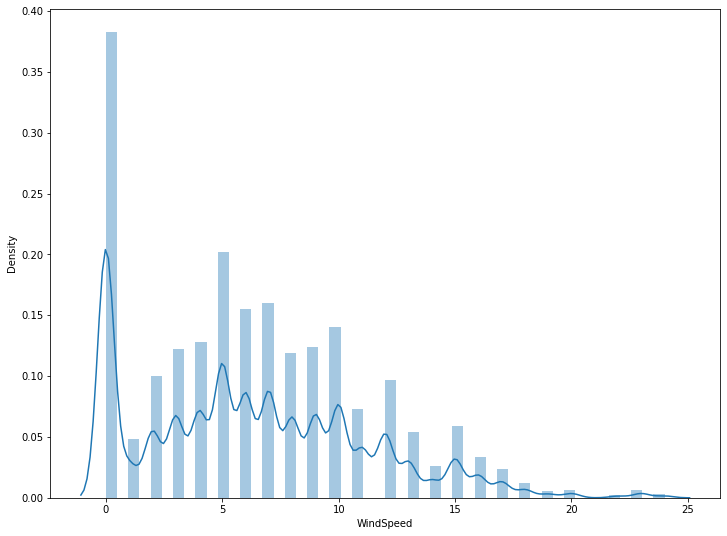

In [17]:
ax = sns.distplot(X_train['WindSpeed'])
ax.figure.set_size_inches(12,9)

In [18]:
#Limpeza e processamento dos dados da coluna Wind Direction, refinando diversos valores possíveis apenas nos valores conhecidos.
def clean_wind_direction(wind_direction):
    wd = str(wind_direction).upper()
    if wd == 'N' or 'FROM N' in wd:
        return 'north'
    if wd == 'S' or 'FROM S' in wd:
        return 'south'
    if wd == 'W' or 'FROM W' in wd:
        return 'west'
    if wd == 'E' or 'FROM E' in wd:
        return 'east'
    if 'FROM SW' in wd or 'FROM SSW' in wd or 'FROM WSW' in wd:
        return 'south west'
    if 'FROM SE' in wd or 'FROM SSE' in wd or 'FROM ESE' in wd:
        return 'south east'
    if 'FROM NW' in wd or 'FROM NNW' in wd or 'FROM WNW' in wd:
        return 'north west'
    if 'FROM NE' in wd or 'FROM NNE' in wd or 'FROM ENE' in wd:
        return 'north east'
    if 'NW' in wd or 'NORTHWEST' in wd:
        return 'north west'
    if 'NE' in wd or 'NORTH EAST' in wd:
        return 'north east'
    if 'SW' in wd or 'SOUTHWEST' in wd:
        return 'south west'
    if 'SE' in wd or 'SOUTHEAST' in wd:
        return 'south east'

    return 'N/A'

X_train['WindDirection'] = X_train['WindDirection'].apply(clean_wind_direction)

In [19]:
#LImpeza e processamento dos dados de teste
X_test['WindDirection'] = X_test['WindDirection'].apply(clean_wind_direction)

In [20]:
X_train['WindDirection'].unique()

array(['south east', 'N/A', 'north east', 'north west', 'south west',
       'east', 'south', 'north', 'west'], dtype=object)

In [21]:
#Preenchimento dos valores nulos da coluna Humidity e Temperature, usando o método ffil, o qual segue.... 
X_train['Humidity'].fillna(method='ffill', inplace=True)
X_train['Temperature'].fillna(method='ffill', inplace=True)

In [22]:
#Preenchimento dos valores nulos da coluna Humidity e Temperature do conjunto de TESTE, usando o método ffil, o qual segue.... 
X_test['Humidity'].fillna(method='ffill', inplace=True)
X_test['Temperature'].fillna(method='ffill', inplace=True)

In [23]:
na_map = {
    # What is the average orientation of the playrees
    'Orientation': X_train['Orientation'].mean(),
    # Average direction 
    'Dir': X_train['Dir'].mean(),
    # Average # of defenders in the box (# of defenders directly opposing person with the ball)
    'DefendersInTheBox': np.math.ceil(X_train['DefendersInTheBox'].mean()),
    # What formation the team is using is really important, but often some teams use custom formations
    # In the case we will just say that we don't know
    'OffenseFormation': 'UNKNOWN'
}

X_train.fillna(na_map, inplace=True)

In [24]:
X_test.fillna(na_map, inplace=True)

In [25]:
#Mapeamento de todos os valores oscilantes dentro da coluna Weather, agrupando estes em apenas 5 valores possiveis, Rain, Overcarst, Clear, Snow e, para casos desconhecidos
#e/ou em ambientes controlados, ex: Estadios fechados, foram mapeados entre controlled. 
def group_game_weather(weather):
    rain = ['Rainy', 'Rain Chance 40%', 'Showers',
            'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
            'Scattered Showers', 'Cloudy, Rain', 'Rain shower', 'Light Rain', 'Rain']

    overcast = ['Cloudy, light snow accumulating 1-3"', 'Party Cloudy', 'Cloudy, chance of rain',
                'Coudy', 'Cloudy, 50% change of rain', 'Rain likely, temps in low 40s.',
                'Cloudy and cold', 'Cloudy, fog started developing in 2nd quarter',
                'Partly Clouidy', '30% Chance of Rain', 'Mostly Coudy', 'Cloudy and Cool',
                'cloudy', 'Partly cloudy', 'Overcast', 'Hazy', 'Mostly cloudy', 'Mostly Cloudy',
                'Partly Cloudy', 'Cloudy']

    clear = ['Partly clear', 'Sunny and clear', 'Sun & clouds', 'Clear and Sunny',
             'Sunny and cold', 'Sunny Skies', 'Clear and Cool', 'Clear and sunny',
             'Sunny, highs to upper 80s', 'Mostly Sunny Skies', 'Cold',
             'Clear and warm', 'Sunny and warm', 'Clear and cold', 'Mostly sunny',
             'T: 51; H: 55; W: NW 10 mph', 'Clear Skies', 'Clear skies', 'Partly sunny',
             'Fair', 'Partly Sunny', 'Mostly Sunny', 'Clear', 'Sunny']

    snow  = ['Heavy lake effect snow', 'Snow']

    controlled  = ['N/A Indoor', 'Indoors', 'Indoor', 'N/A (Indoors)', 'Controlled Climate']
    
    if weather in rain:
        return 'rain'
    elif weather in overcast:
        return 'overcast'
    elif weather in clear:
        return 'clear'
    elif weather in snow:
        return 'snow'
    elif weather in controlled:
        return 'controlled'
    
    return 'controlled'

In [26]:
#Dados de treino
X_train['GameWeather'] = X_train['GameWeather'].apply(group_game_weather)
X_train['FieldPosition'] = np.where(X_train['YardLine'] == 50, X_train['PossessionTeam'], X_train['FieldPosition'])

In [27]:
#Dados de teste
X_test['GameWeather'] = X_test['GameWeather'].apply(group_game_weather)
X_test['FieldPosition'] = np.where(X_test['YardLine'] == 50, X_test['PossessionTeam'], X_test['FieldPosition'])

In [28]:
#Para a coluna de Stadium Type, também foi realizado o agrupado dos valores, visto que temos valores que diferem, porém possuem o mesmo significado.
def group_stadium_types(stadium):
    outdoor = ['Outdoor', 'Outdoors', 'Cloudy', 'Heinz Field', 
               'Outdor', 'Ourdoor', 'Outside', 'Outddors', 
               'Outdoor Retr Roof-Open', 'Oudoor', 'Bowl']

    indoor_closed = ['Indoors', 'Indoor', 'Indoor, Roof Closed', 'Indoor, Roof Closed', 
                    'Retractable Roof', 'Retr. Roof-Closed', 'Retr. Roof - Closed', 'Retr. Roof Closed',]

    indoor_open   = ['Indoor, Open Roof', 'Open', 'Retr. Roof-Open', 'Retr. Roof - Open']

    dome_closed   = ['Dome', 'Domed, closed', 'Closed Dome', 'Domed', 'Dome, closed']
    
    dome_open     = ['Domed, Open', 'Domed, open']
    
    if stadium in outdoor:
        return 'outdoor'
    elif stadium in indoor_closed:
        return 'indoor closed'
    elif stadium in indoor_open:
        return 'indoor open'
    elif stadium in dome_closed:
        return 'dome closed'
    elif stadium in dome_open:
        return 'dome open'
    else:
        return 'unknown'
    
X_train['StadiumType'] = X_train['StadiumType'].apply(group_stadium_types)

In [29]:
#Dados de teste
X_test['StadiumType'] = X_test['StadiumType'].apply(group_stadium_types)

In [30]:
#Dados de treino
X_train['PlayerHeight']=X_train['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [31]:
#Dados de teste
X_test['PlayerHeight']=X_test['PlayerHeight'].apply(lambda x : np.mean(list(map(int,x.split('-')))))

In [32]:
X_train['PlayerHeight'].unique()

array([5. , 5.5, 3.5, 4. , 8. , 3. , 6. , 4.5, 6.5, 7.5, 7. ])

In [33]:
def process_defense(x):
    num=[]
    num=x.split(',')
    dl=int(num[0].split(' ')[0])
    lb=int(num[1].split(' ')[1])
    db=int(num[2].split(' ')[1])
    if(len(num)>3):
         ol=int(num[3].split(' ')[1])
    else:
         ol=0
    return [dl,lb,db,ol]

values=X_train['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_train['DL']=u
X_train['LB']=v
X_train['BL']=x
X_train['OL']=y
X_train.drop(['DefensePersonnel'],axis=1,inplace=True)

In [34]:
#Dados de teste
values=X_test['DefensePersonnel'].apply(process_defense)
u,v,x,y=list(map(list,zip(*values)))

X_test['DL']=u
X_test['LB']=v
X_test['BL']=x
X_test['OL']=y
X_test.drop(['DefensePersonnel'],axis=1,inplace=True)

In [35]:
ColumnsToEncoding=[]
for c in X_train.columns:
    if(X_train[c].dtype != int):
            try:
                X_train[c]=X_train[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_train[c].values)
    lbdic[c]=lb
    X_train[c]=lb.transform(X_train[c].values)

In [36]:
#Enconding dados de teste
ColumnsToEncoding=[]
for c in X_test.columns:
    if(X_test[c].dtype != int):
            try:
                X_test[c]=X_test[c].astype('float16')
            except:
                ColumnsToEncoding.append(c)

lbdic={}
for c in ColumnsToEncoding:
    lb=LabelEncoder()
    lb=lb.fit(X_test[c].values)
    lbdic[c]=lb
    X_test[c]=lb.transform(X_test[c].values)

In [37]:
X_test.head(5)

,X,Y,S,A,Dis,Orientation,Dir,NflId,DisplayName,JerseyNumber,...,Temperature,Humidity,WindSpeed,WindDirection,ResultAfterMove,IsHomeTeam,DL,LB,BL,OL
key,,,,,,,,,,,,,,,,,,,,,
2018123001-20181230012906,50.68750,45.343750,5.140625,2.080078,0.509766,79.125000,65.00000,2552409,707,11,...,33.0,75.0,9,7,1,0,4,2,5,0
2018091000-20180910001480,90.93750,16.281250,1.459961,1.299805,0.150024,23.234375,359.50000,2533059,1812,21,...,68.0,70.0,0,0,0,0,3,3,5,0
2018121607-20181216070996,37.84375,34.656250,4.171875,1.209961,0.409912,85.562500,90.00000,2649,608,80,...,68.0,70.0,0,0,1,0,4,2,5,0
2019100300-20191003003419,70.25000,29.546875,2.230469,0.859863,0.219971,62.750000,280.25000,2557881,2254,33,...,57.0,56.0,7,7,0,1,4,3,4,0
2018102106-20181021060782,18.06250,25.812500,0.600098,2.060547,0.049988,85.812500,29.90625,2530556,1482,79,...,89.0,51.0,8,2,1,0,4,2,5,0


In [38]:
#Aplicação de scaler nos dados. RobustScaler apresentou a melhor performance nos modelos testados.
SS = StandardScaler()
MM = MinMaxScaler()
RS = RobustScaler()

X_train_scaled = RS.fit_transform(X_train)
X_test_scaled = RS.fit_transform(X_test)

#XGBoost - Custom
#Custom parameters and datasets converted in Dmatrix
#R2 = 59,25% e MSE = 16,94%

In [57]:
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score


# Transformando conjuntos de treinamento e teste em DMatrices
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

# Definindo parâmetros do modelo
params = {
    "objective":"reg:squarederror",
    "max_depth":10,
    "eta":0.1,
    "eval_metric":"rmse"
}

# Treinando o modelo
model_n = xgb.train(params=params, dtrain=dtrain, num_boost_round=100)

# Fazendo previsões no conjunto de teste
preds = model_n.predict(dtest)
#pred_proba = model_n.predict_proba(dtest)

# Avaliar o modelo
mse_n = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("Mean Squared Error: ", mse_n)
print("R2 Score: ", r2)

Mean Squared Error:  5.665226881205772
R2 Score:  0.8638665128687959


In [58]:
df_results = pd.DataFrame(y_test)
df_results['Predicted'] = preds

In [59]:
df_results.head(10)

,Yards,Predicted
key,,
2018123001-20181230012906,8,10.747955
2018091000-20180910001480,3,2.635701
2018121607-20181216070996,10,11.377039
2019100300-20191003003419,2,3.762650
2018102106-20181021060782,71,66.391159
2019102003-20191020032914,-2,-2.028712
2017123101-20171231011873,21,19.030067
2018102811-20181028111933,7,4.146588
2017121707-20171217073353,6,3.786949


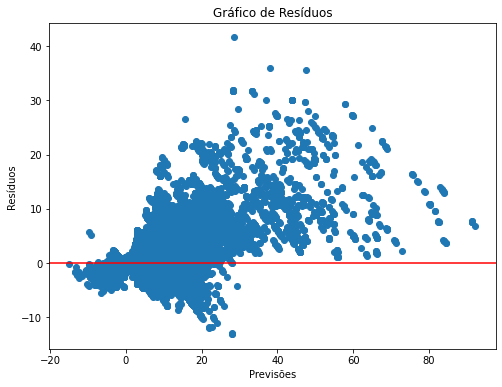

In [60]:
# Plot do gráfico de resíduos do modelo.
residuals = y_test - preds

# Plotar o gráfico de resíduos
fig = plt.figure(figsize=(8, 6))
plt.scatter(preds, residuals)
plt.xlabel('Previsões')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Gráfico de Resíduos')
plt.show()

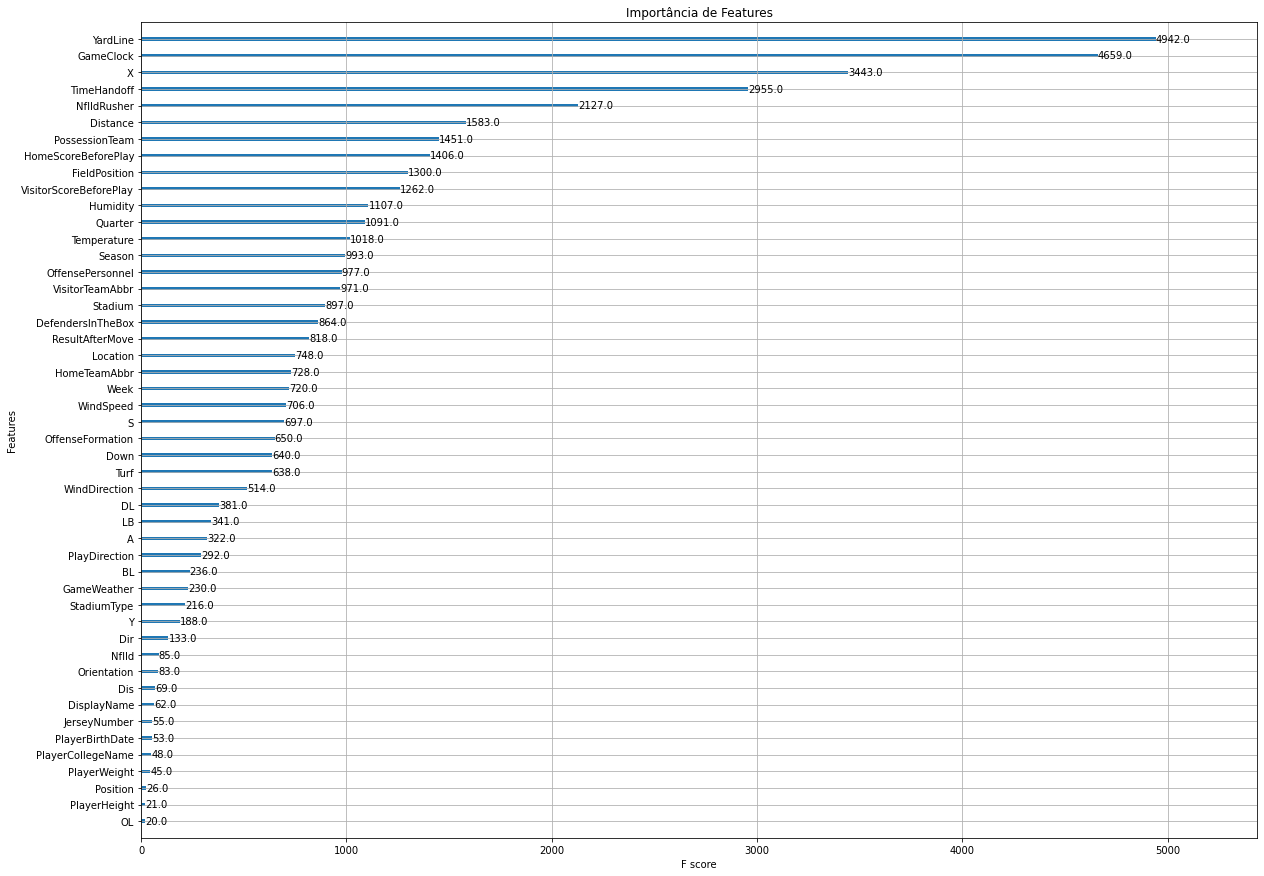

In [61]:
#Grafico de importância de features, mensurado pelo F1-Score
fig = plt.figure(figsize=(20, 15))
xgb.plot_importance(model_n, ax=plt.gca())
plt.title("Importância de Features")
plt.show()

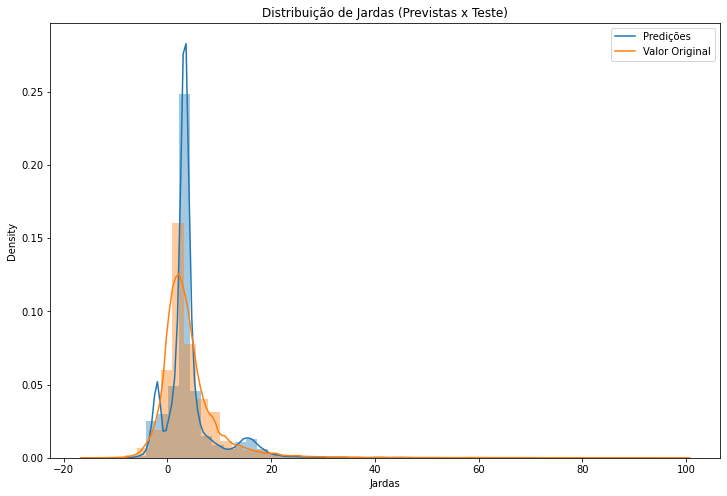

In [62]:
#Distribuição de jardas entre dados de teste e predições
graphs = []
ax = sns.distplot(preds,)
ax = sns.distplot(y_test.values)
plt.legend(labels=["Predições","Valor Original"])
plt.title('Distribuição de Jardas (Previstas x Teste)')
plt.xlabel('Jardas')
ax.figure.set_size_inches(12,8)

In [ ]:
# Define os parâmetros para a busca em grade
param_grid = {
    'n_estimators': [100, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Cria o modelo XGBoost
xgb = XGBRegressor(random_state=42)

# Executa a busca em grade com validação cruzada
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

# Imprime os melhores parâmetros encontrados
print(grid_search.best_params_)

# Faz as previsões no conjunto de teste
y_pred = grid_search.predict(X_test_scaled)

# Calcula o erro quadrático médio
mse = mean_squared_error(y_test, y_pred)
print('Erro quadrático médio: %.2f' % mse)

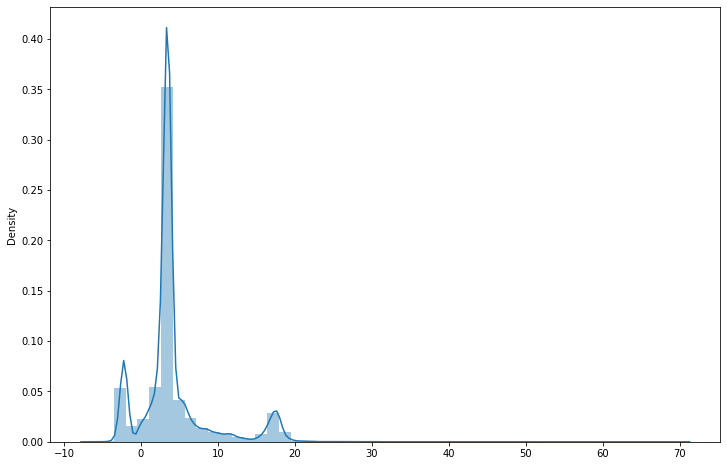

In [ ]:
#Distribuição de jardas
ax = sns.distplot(preds)
ax.figure.set_size_inches(12,8)

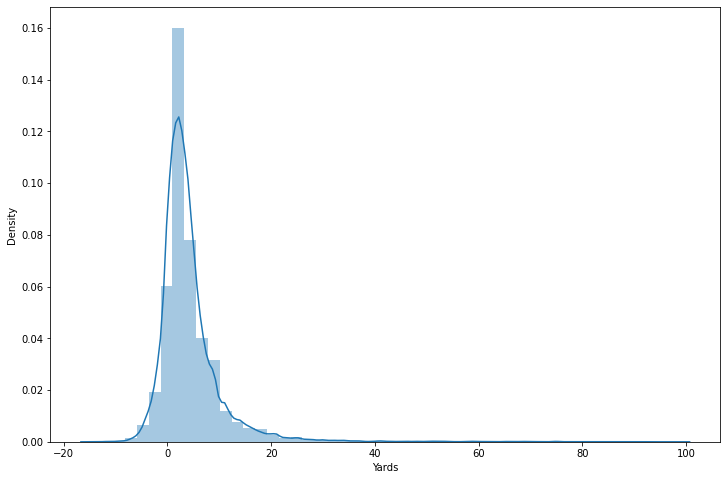

In [ ]:
#Distribuição de jardas
ax = sns.distplot(y_test)
ax.figure.set_size_inches(12,8)

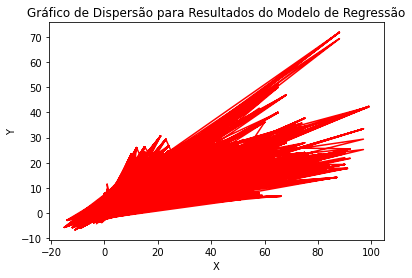

In [ ]:
# Plot do gráfico de dispersão
#plt.scatter(y_test, preds)

# Plot da linha de tendência
plt.plot(y_test, preds, color='red')

# Adicionando rótulos e legendas ao gráfico
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Gráfico de Dispersão para Resultados do Modelo de Regressão')

# Exibindo o gráfico
plt.show()

#XGBoost - Standard
##Modelo standard, RobustScaler R2 = 53% MSE = 19%

In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd

# Instanciar o modelo XGBoost
model = xgb.XGBRegressor()

# Treinar o modelo usando os dados de treinamento
model.fit(X_train_scaled, y_train)

# Fazer previsões nos dados de teste
predictions = model.predict(X_test_scaled)

# Avaliar o modelo
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("Mean Squared Error: ", mse)
print("R2 Score: ", r2)

[22:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Mean Squared Error:  19.31046632012257
R2 Score:  0.5361252826268699
